# Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import re
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.corpus import wordnet
import enchant
from collections import Counter
import spacy
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer

# Download the Data from Kaggle

In [2]:
#Create the API to interact with Kaggle
api = KaggleApi()
#Authenticate using API credentials
api.authenticate()

In [5]:
#Download the competition files
api.competition_download_files('nlp-getting-started')
#Open the zip file
zf = ZipFile('nlp-getting-started.zip')
#Extract the files and specify the location
zf.extractall("data\\") 
#Close the zip file
zf.close()

# Read in the Training Data

In [33]:
tweets = pd.read_csv("data/train.csv")

In [3]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
tweets.drop(["id", "keyword", "location"], axis = 1, inplace=True)

In [35]:
tweets.isnull().sum()

text      0
target    0
dtype: int64

# Data Preprocessing and Normalization

In [6]:
def strip_html_tags(text):
    """
    This function removes unnecessary HTML tags in the corpus. 
    
    test: corpus of text data
    
    returns: text with no HTML

    """
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(["iframe", "script"])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    
    return stripped_text

In [7]:
def text_tokenizer(text):
    """
    This function takes a corpus and tokenizes it into sentences
    Parameters
    
    test: String containing the corpus
    
    returns: Corpus of tokenized sentences

    """
    tokenizer = nltk.sent_tokenize
    sentence_tokens = tokenizer(text=text)
    return sentence_tokens 


In [8]:
def word_tokenizer(text):
    """
    This function takes a corpus and splits the sentences into words
    
    test: String of tokenized sentences
    
    returns: Array of tokenized words

    """
    tokenizer = nltk.word_tokenize
    word_tokens = tokenizer(text)
    return np.array(word_tokens)


In [9]:
def remove_accented_chars(text):
    """
    This function removes accented characters from the corpus using ASCII
    characters
    
    text: String corpus of text data
    
    returns: Corpus with all characters converted and standardized into ASCII characters

    """
    
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [10]:
#This map was gotten from the internet

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"}

def expand_contractions(text, contraction_mapping = CONTRACTION_MAP):
    """
    This function takes a corpus of text data and expands all contractions
    bassed on the contraction mapping
    
    text: String corpus of text data
    
    returns: Text corpus with all contractions expanded

    """
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [11]:
def remove_special_characters(text, remove_digits = False):
    """
    This function returns the text corpus with all special characters removed with the option
    to remove digits
    
    text: String corpus
    
    returns: Text corpus with special characters removed

    """
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [12]:
def case_conversation(text, text_lower = True):
    """
    This function returns the corpus with all tokens lowercase or uppercase
    
    text: String corpus
    text_lower: Boolen, default is True
    
    returns: Text corpus with all tokens converted

    """
    if text_lower:
        return text.lower()
    else:
        return text.upper()

In [13]:
nlp = spacy.load('en_core_web_sm')
def lemmatize(text):
    """
    This function returns the lemmatized text corpus. Gives correct spelling. 

    text: String corpus
    
    returns: String of lemmatized text corpus
    """
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [14]:
def remove_stopwords(text, is_lower_case=False):
    """
    This function removes all the stopwords from the text corpus based on the pre-existing 
    list of stopwords from nltk. 
    
    text: String corpus
    is_lower_case: Boolean to make the corpus lower case
    
    returns: String corpus with stopwords removed

    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [15]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def normalize_corpus(corpus, html_stripping = True, contraction_expansion = True, accented_char_removal = True, 
                     text_lower_case = True, text_lemmatization = True, special_char_removal = True, stopword_removal=True, 
                     remove_digits = True):
    """
    This function normalizes the text corpus based on all the functions above. 

    corpus : Text corpus
    html_stripping : boolean, optional
        Controls if the text corpus is stripped of htmls
    contraction_expansion : boolean, optional
        Controls if the text corpus has its contractions extraction
    accented_char_removal : boolean, optional
        Controls if the text corpus has its accented characters removed
    text_lower_case : boolean, optional
        Controls if the text corpus has its text changed to lower case
    correct_spelling : boolean, optional
        Controls if the text corpus has its spelling corrected
    text_lemmatization : boolean, optional
        Controls if the text corpus his its words lemmatized
    special_char_removal : boolean, optional
        Controls if the text corpus has its special characters removed
    stopword_removal : boolean, optional
        Controls if the text corpus has its stopwords removed
    remove_digits : boolean, optional
        Controls if the text corpus has its digits removed

    returns: String of normalized text corpus
    """
    
    normalized_corpus = []

    for doc in corpus:
        
        if html_stripping:
            doc = strip_html_tags(doc)
            
        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        if contraction_expansion:
            doc = expand_contractions(doc)
            
        if text_lower_case:
            doc = case_conversation(doc)
            
        #Remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
            
        if text_lemmatization:
            doc = lemmatize(doc)
            
        if special_char_removal:
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
            
        #Removes extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

### Normalize the Corpus of Tweets

In [16]:
%%time
stopword_list.remove("no")
stopword_list.remove("not")

corpus = tweets["text"]
norm_corpus = np.array(normalize_corpus(corpus))

tweets["Clean Tweets"] = norm_corpus

Wall time: 2min 8s


In [17]:
pd.set_option('display.max_colwidth', 2)
tweets.head(n=10)

,text,target,Clean Tweets
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer no evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got send photo ruby alaska smoke wildfire pour school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,rockyfire update california hwy close direction due lake county fire cafire wildfire
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster heavy rain cause flash flooding street manitou colorado spring area
7,I'm on top of the hill and I can see a fire in the woods...,1,I top hill I see fire wood
8,There's an emergency evacuation happening now in the building across the street,1,emergency evacuation happen building across street
9,I'm afraid that the tornado is coming to our area...,1,I afraid tornado come area


Check if normalizing resulted in any rows having a missing value

In [18]:
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
tweets.isnull().sum()

text            0
target          0
Clean Tweets    0
dtype: int64

## Analyze Word Occurence

### Analyze the most common words

In [717]:
# Create a list of all words used in safe tweets
words = [word for row in tweets["Clean Tweets"] for word in row.split()]
# Create a counter to count the words
word_cnt = Counter(words)
# Create a dictionary of the words
word_dict = dict(word_cnt.most_common())
# Create a dataframe with words and their count
word_df = pd.DataFrame({"Word": word_dict.keys(), "Count": word_dict.values()})
# Create a new column with the word percentage
word_df["Percentage"] = (word_df["Count"] / len(words)) * 100
word_df.head(n=10)

,Word,Count,Percentage
0,httpt,4307,5.244764
1,I,2104,2.562104
2,not,754,0.918169
3,_,423,0.515100
4,httpst,409,0.498052
5,like,395,0.481003
6,get,375,0.456649
7,fire,359,0.437165
8,go,276,0.336094
9,no,266,0.323916


In [30]:
#How many unique "words" are in the data
word_df.shape[0]

18954

Text(0.5, 1.0, 'Top 30 Words By Percentage')

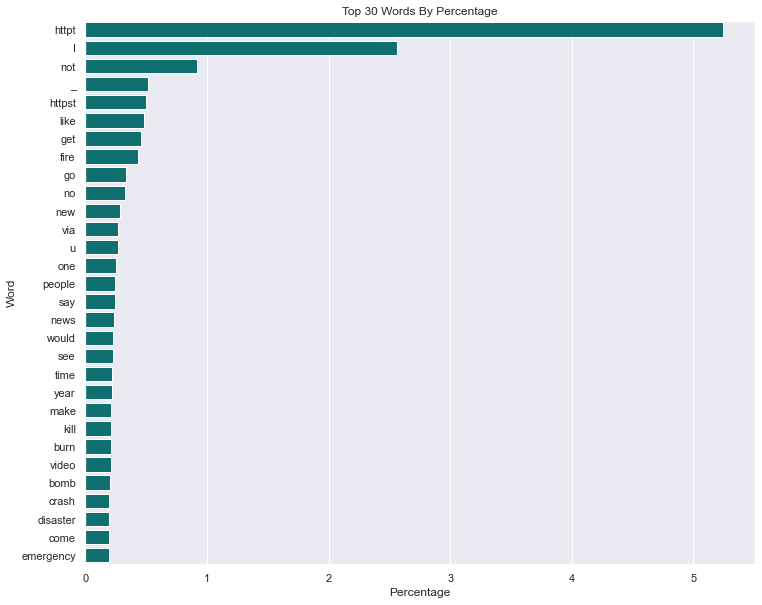

In [22]:
#Plot the top 30 words ranked by their percentage
sns.set(rc = {'figure.figsize':(12,10)})
sns.barplot(x="Percentage", y="Word", data = word_df[:30], color = "teal")
plt.title("Top 30 Words By Percentage")

In [72]:
word_grp_df = pd.DataFrame(word_df["Count"]\
                                           .value_counts()\
                                           .reset_index()\
                                           .rename(columns={"index": "Word Occurrence", "Count" :"Number of Words"}))\
                                            .sort_values(by="Word Occurrence")
word_grp_df[["Number of Words", "Word Occurrence"]]

,Number of Words,Word Occurrence
0,13456,1
1,1785,2
2,793,3
3,512,4
4,371,5
...,...,...
137,1,409
144,1,423
120,1,754
134,1,2104


In [718]:
#View the type of words that occur only once
word_df.loc[word_df["Count"] == 1].head(n=20)

,Word,Count,Percentage
5498,ronge,1,0.001218
5499,sask,1,0.001218
5500,notify,1,0.001218
5501,ruby,1,0.001218
5502,manitou,1,0.001218
5503,fvck,1,0.001218
5504,tampabay,1,0.001218
5505,goooooooaaaaaal,1,0.001218
5506,skiing,1,0.001218
5507,looooool,1,0.001218


We see some of these words are either mispelled such as "cooool" and "fvck" while some are giberish. We'll go ahead and remove all words that are giberish or mispelled. We'll do this by removing words that don't appear in nltk's wordnet corpus and those words that are not spelled correctly will be determined by PyEnchant.

In [19]:
spell_checker = enchant.Dict("en_US")

def valid_word(text):
    """
    This function returns a boolean value on if it exists in the wordnet corpus and if it is spelled correctly.
    
    text: Word to check
    
    returns: correct_word: boolean 
    """
    correct_word = (len(wordnet.synsets(text)) != 0 & spell_checker.check(text))
    return correct_word

In [721]:
word_df["Valid Word"] = word_df["Word"].apply(valid_word)

In [722]:
#Check the number of words that are invalid compared to valid
word_df["Valid Word"].value_counts()

False    11473
True     7481 
Name: Valid Word, dtype: int64

In [723]:
#Words that are not valid
word_df.loc[(word_df["Valid Word"] == False)]

,Word,Count,Percentage,Valid Word
0,httpt,4307,5.244764,False
3,_,423,0.515100,False
4,httpst,409,0.498052,False
11,via,220,0.267901,False
17,would,187,0.227716,False
...,...,...,...,...
18948,forney,1,0.001218,False
18950,corqkkuhey,1,0.001218,False
18951,conficuloje,1,0.001218,False
18952,costfmbbzfb,1,0.001218,False


We'll make some functions that will help us remove individual words from tweets

In [21]:
def make_pattern(df):
    """
    This function makes the pattern of words based on if they are valid.
    
    df: Dataframe with the required columns.
    
    returns: bad_words_list containing a list of all the words to remove
    """
    
    # Create a list of all words used in safe tweets
    words = [word for row in df["Clean Tweets"] for word in row.split()]
    # Create a counter to count the words
    word_cnt = Counter(words)
    # Create a dictionary of the words
    word_dict = dict(word_cnt.most_common())
    # Create a dataframe with words and their count
    word_df = pd.DataFrame({"Word": word_dict.keys(), "Count": word_dict.values()})
    # Create a new column with the word percentage
    word_df["Percentage"] = (word_df["Count"] / len(words)) * 100
    # Create a new column with a flag for valid words
    word_df["Valid Word"] = word_df["Word"].apply(valid_word)
    # Create a list of words that are invalid
    bad_words_list = list(word_df.loc[(word_df["Valid Word"] == False), "Word"])
    
    #This is special situation that has to be hardcoded. A explict "\" has to be added to escape the "["
    bad_words_list.index("famine[")
    bad_words_list[bad_words_list.index("famine[")] = "famine\["
    
    return bad_words_list

In [20]:
def remove_words(text, pattern):
    """
    This function removes words based on those found in the pattern.
    
    test: String of text
    pattern: List of words to remove
    
    returns: new string with specified words removed
    """

    new_string = re.sub(r"\b(%s)\b" % "|".join(pattern), "", text, flags=re.I)
    return new_string

We can check which words were not removed but should have been. Usually, these words would be manually removed but after numerous different attempts to remove them failed they will remain, for now. 

In [443]:
word_df["Correct Words"] = word_df["Word"].apply(remove_words, pattern = bad_words_list)
word_df.loc[(word_df["Valid Word"] == False) & (word_df["Correct Words"] != '')]

,Word,Count,Percentage,Valid Word,Correct Words
44,[,131,0.159523,False,[
45,],131,0.159523,False,]
3539,`,3,0.003653,False,`
4346,^ag,2,0.002435,False,^ag
8313,^mp,1,0.001218,False,^mp
8540,^oo^,1,0.001218,False,^oo^
10272,destruction\s,1,0.001218,False,destruction\s
11020,\\\,1,0.001218,False,\\\
11021,omar_molina,1,0.001218,False,omar_molina
11290,\a,1,0.001218,False,\a


### Remove invalid or mispelled words from the data

In [29]:
%%time
bad_words_list = make_pattern(tweets)

tweets["Cleaner Tweets"] = tweets["Clean Tweets"].apply(remove_words, pattern = bad_words_list)

Wall time: 43.1 s


Let's take a look at some of our "dirtiest" tweets. We can see that after normalizer and removing invalid words, we are left with a much better corpus of tweets. 

In [30]:
tweets.loc[tweets["Clean Tweets"].str.contains("httpt")].head(n=20)

,text,target,Clean Tweets,Cleaner Tweets
31,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,bbcmtd wholesale market ablaze httpt colhyxeohyc,wholesale market ablaze
32,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,always try bring heavy metal rt httpt coyaoexngw,always try bring heavy metal
33,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,africanbaze break news nigeria flag set ablaze aba httpt conndbgwyei,break news nigeria flag set ablaze aba
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,plus side look sky last night ablaze httpt coqqsmshajn,plus side look sky last night ablaze
37,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,inec office abia set ablaze httpt coimaomknna,office set ablaze
38,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1,barbado bridgetown jamaica uo two car set ablaze santa cruz uo head st elizabeth police superintende httpt cowdueajqj,bridgetown jamaica two car set ablaze santa head elizabeth police
40,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,check httpt coroinsmejj httpt cotjzjin httpt coyduixefipe httpt colxtjckls nsfw,check
44,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0,I want set chicago ablaze preaching not hotel httpt cooqknbfofx,I want set chicago ablaze preaching not hotel
45,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0,I gain follower last week know stat grow httpt cotiyulifc,I gain follower last week know grow
46,How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1,west burn thousand wildfire ablaze california alone httpt covltbrwbr,west burn thousand wildfire ablaze california alone


Check if removing any invalid words resulted in tweets with missing values. 

In [31]:
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
tweets.isnull().sum()

text              0
target            0
Clean Tweets      0
Cleaner Tweets    0
dtype: int64

In [32]:
tweets.loc[tweets["Cleaner Tweets"].isnull()]

,text,target,Clean Tweets,Cleaner Tweets


In [27]:
tweets.dropna(subset=["Cleaner Tweets"], inplace = True)

# Package all cleaning functions into one

In [39]:
def tweet_scruber(df, drop_columns = True, normalize = True, remove_invalid = True, drop_missing=True, verbose=False):
    """
    This function is a wrapper over the various functions used to clean the Twitter data.
    
    df: DataFrame with the necessary columns
    drop_columns: Boolean to determine if unnecessary columns should be dropped
    normalize: Boolean to determine if tweets should be normalized
    remove_invalid: Boolean to determine if invalid words in tweets should be removed
    drop_missing: Boolean to determine if missing rows after normalizing and removing invalid words should be dropped
    verbose: Boolean to determine if progress should be printed
    """
    
    if verbose: print("Running tweet scruber...\n")
    
    if drop_columns:
        if verbose: print("Dropping unnecessary columns")
        df = df.drop(["id", "keyword", "location"], axis = 1)
        if verbose: print("Successfully dropped columns!\n")
            
    if normalize:
        if verbose: print("Normalizing the tweets")
        df["Clean Tweets"] = np.array(normalize_corpus(df["text"]))
        if verbose: print("Successfully normalized tweets!\n")
            
    if remove_invalid:
        if verbose: print("Removing invaled and mispelled words")
        bad_words_list = make_pattern(df)
        df["Clean Tweets"] = df["Clean Tweets"].apply(remove_words, pattern = bad_words_list)
        if verbose: print("Successfully removed invalid and mispelled words!\n")
            
    if drop_missing:
        if verbose: print("Dropping tweets with no words")
        df = df.dropna(subset=["Clean Tweets"])
        if verbose: print("Successfully dropped tweets!")
        
    return df
    
    

In [38]:
tweets = pd.read_csv("data/train.csv")

In [40]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [41]:
%%time

tweets = tweet_scruber(tweets, verbose = True)

Running tweet scruber...

Dropping unnecessary columns
Successfully dropped columns!
Normalizing the tweets
Successfully normalized tweets!
Removing invaled and mispelled words
Successfully removed invalid and mispelled words!
Dropping tweets with no words
Successfully dropped tweets!
Wall time: 1min 59s


In [49]:
tweets.loc[tweets["text"].str.contains("http")].head(n=20)

,text,target,Clean Tweets
31,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,wholesale market ablaze
32,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,always try bring heavy metal
33,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,break news nigeria flag set ablaze aba
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,plus side look sky last night ablaze
37,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,office set ablaze
38,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1,bridgetown jamaica two car set ablaze santa head elizabeth police
40,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,check
44,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0,I want set chicago ablaze preaching not hotel
45,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0,I gain follower last week know grow
46,How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1,west burn thousand wildfire ablaze california alone


Now that we have thoroughly cleaned up the data set, we can move on to visualizing the tweets.  